In [23]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image 

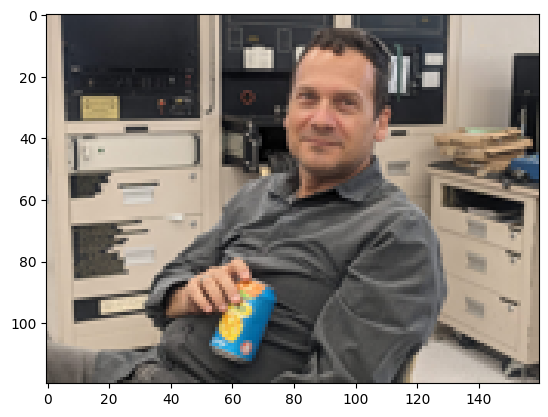

In [24]:
image_path = 'C:\\Users\\bkand\\Downloads\\tanya-images\\ashush_body.jpeg'
image_path = 'C:\\Users\\bkand\\Downloads\\shilon.jpeg'

with Image.open(image_path) as im: 
    w, h = im.size; ratio = w/h
    im = im.resize((int(ratio*120), 120))
    img = np.asarray(im)
plt.imshow(img)

In [25]:
# Bayers dithering levels
M2 = (1/4) * np.array([
    0, 2, 
    3, 1
]).reshape(2, 2)

M4 = (1/16) * np.array([
    0, 8, 2, 10, 
    12, 4, 14, 6, 
    3, 11, 1, 9, 
    15, 7, 13, 5
]).reshape(4, 4)

M8 = (1/64) * np.array([
    0, 32, 8, 40, 2, 32, 10, 42, 
    48, 16, 56, 24, 50, 18, 58, 26, 
    12, 44, 4, 26, 14, 46, 6, 38, 
    60, 28, 52, 20, 62, 30, 54, 22, 
    3, 35, 11, 43, 1, 33, 9, 41, 
    51, 19, 59, 27, 49, 17, 57, 25, 
    15, 47, 7, 39, 13, 45, 5, 37, 
    63, 31, 55, 23, 61, 29, 53, 21
]).reshape(8, 8)

color_palette = np.array([ 
    [0 ,0 ,0], # black 
    [255, 0, 0], # red
    [0, 255, 0], # green
    [255, 255, 0], # yellow
    [0, 0, 255], # blue
    [255, 0, 255], # magenta
    [255, 255, 255], # white
    [150, 75, 0], # brown
    [0, 127, 127], # cyan50

    [127, 0, 0], # red50
    [0, 127, 0], # green50
    [127, 127, 0], # yellow50
    [0, 0, 127], # blue50
    [127, 0, 127], # magenta50
    [192, 192, 192] # gray75
])

color_palette_names = [ 
    'Black', 'Red', 'Green', 'Yellow', 'Blue', 'Magenta', 'White', 'Brown', 'Cyan50', 'Red50', 'Green50', 'Yellow50', 'Blue50', 'Magenta50', 'Gray75'
]

def nearest_color_palette(c): 
    # quantizing to 16 colors
    c_hat = np.clip((255 * c), 0, 255).astype('uint8')
    err = ((color_palette - c_hat)**2).sum(axis=1)
    idx = np.argmin(err) # the index of minimum error
    return color_palette_names[idx], color_palette[idx]

n = 8 # color num
w, h = img.shape[:2]
r = 1 # 255/n  # spread 

new_img = np.zeros(img.shape)
new_img_img = ''
for x in range(w):
    for y in range(h):
        pixel_name, pixel = nearest_color_palette( (1/255)*img[x, y] + r * M8[x%8, y%8] -.5)
        new_img[x, y] = pixel
        new_img_img += f'Dot {pixel_name}, {x}, {y}\n'

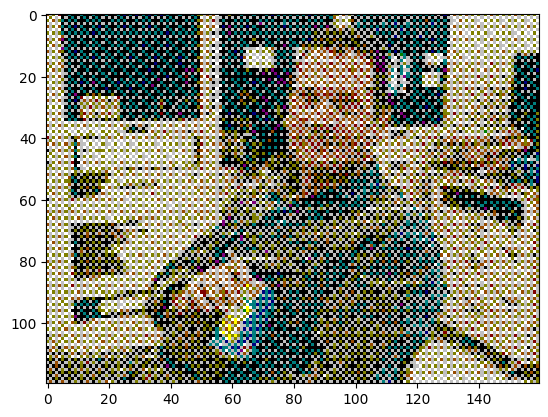

In [26]:
plt.imshow(new_img.astype('uint8'))

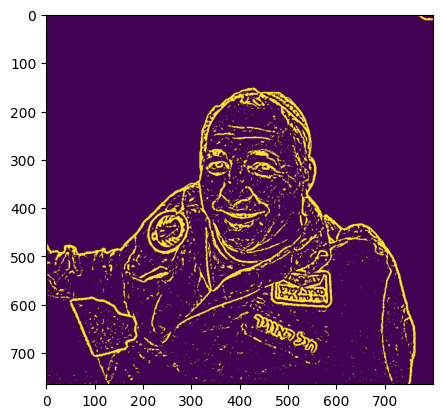

In [33]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np 
image_path = 'ashush_body.jpeg'

img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

img = cv.medianBlur(img,5)
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
gray_threshold = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,2)
plt.imshow(gray_threshold)
gray_bitwise_hed_and_threshold = gray_threshold

Found 2088 raw contours.
78
line count: 459
optimal file size:  921
78


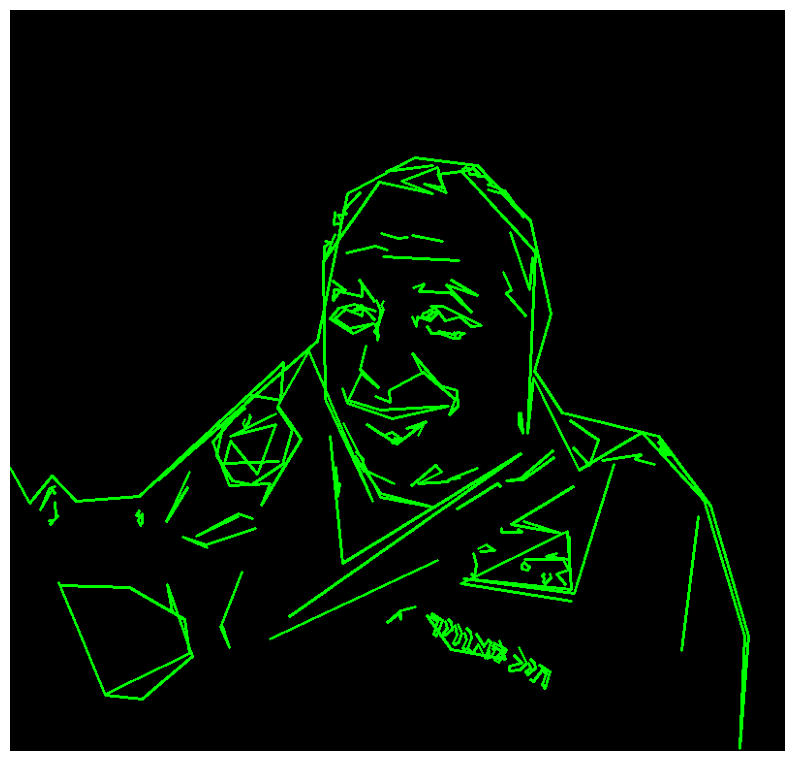

In [ ]:
import cv2

# ashush
min_area_threshold = 40
epsilon_factor_lo, epsilon_factor_hi = 0.032, 0.003

# shilon
# min_area_threshold = 100
# epsilon_factor_lo, epsilon_factor_hi = 0.06, 0.003

contours, hierarchy = cv.findContours(gray_bitwise_hed_and_threshold, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
output_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # 3 channels for color

filtered_contours = []
vectorized_lines = []

print(f"Found {len(contours)} raw contours.")

contour_counter = 0
vector_to_macro = []
for i, contour in enumerate(contours):

  # Filter out small contours which might be noise
  area = cv.contourArea(contour)
  if area < min_area_threshold:
    continue

  perimeter = cv2.arcLength(contour, True)

  # NOTE: fine tune the epsilon factor to your needs ( larger contours need more details )
  epsilon_factor = epsilon_factor_hi if contour.shape[0] > 1000 else epsilon_factor_lo
  epsilon = epsilon_factor * perimeter
  if 50 < contour_counter and contour_counter < 60:
    epsilon = 0.016 * perimeter
  contour_counter += 1

  # Approximate the contour with a polygon (Ramer-Douglas-Peucker algorithm)
  approx = cv2.approxPolyDP(contour, epsilon, True)
  
  # Store the line segments
  # Each point in 'approx' is a vertex of the simplified polygon.
  # We connect consecutive points to form line segments.
  # print(f"Contour {i} (Area: {area:.2f}, Simplified points: {len(approx)}):")
  approx_lines = []
  for j in range(len(approx)):
    p1 = approx[j][0]
    p2 = approx[(j + 1) % len(approx)][0] # Connect last point to first for closed contour
    line_segment = [list(p1), list(p2)]
    vectorized_lines.append(line_segment)
    approx_lines.append(list(p1))
  vector_to_macro.append(approx_lines)

# Draw the final resulting image
vector_to_macro = vector_to_macro[6:-1] # for this one specific case I want to remove the these contours since it looks better
for lines in vector_to_macro: 
  for line in zip(lines, lines[1:]):
    p1, p2 = line
    cv.line(output_image,p1, p2,(0, 255,0),2)

plt.subplots(figsize=(10, 10))
plt.axis('off')
plt.imshow(output_image)

print('line count:', len(sum(vector_to_macro, [])))
line_cnt = len(sum(vector_to_macro, []))
print(f'optimal file size: ', 1 + 2 + 1 + line_cnt * 2 -1)
print(contour_counter)

1062

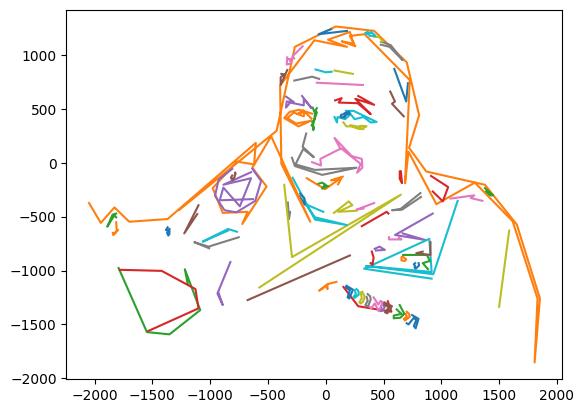

In [27]:
def vector(program, data):
  opcode = [
    0x9000+len(data)-1, # cmd + xy data words
    2+len(program) # offset from the 0x9000 instruction itself (1 for the offset itself, and another 1 for the 0x803 instruction)
  ]
  centered_data = map(lambda x: int((x/800)*0x1000)-0x800, sum(data, [])) # transform to mpd coords to be centered around the 0
  ycorrected_data = [-x if (i % 2) == 1 else x for i, x in enumerate(centered_data)] # flip the y to correct for last transformation
  def defl_x(x): return ((x + 0x7ff) | 0x1800) if (-2047 < x and x < 0) else x
  macro_xy_words = list(map(defl_x, ycorrected_data))
  macro_xy_words[-2] |= 0x8000 # add bright-up bit for last word
  plt.plot(ycorrected_data[::2], ycorrected_data[1::2])
  return opcode, macro_xy_words

program = [0x803]  # end of program word 
for lines in vector_to_macro:
  opcode, macro_xy_words = vector(program, lines)
  program = opcode + program + macro_xy_words
program = [0x7000] + program # begin of program word 
len(program)

# result = ""
# for word in program: 
#   print(f'{word&0xffff:04x}')
  # result += f'{word&0xffff:04x}\n'

# with open('ashush.mcr', 'w+') as f: 
#   f.write(result)

# result